In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

In [0]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train', 'validation']
)

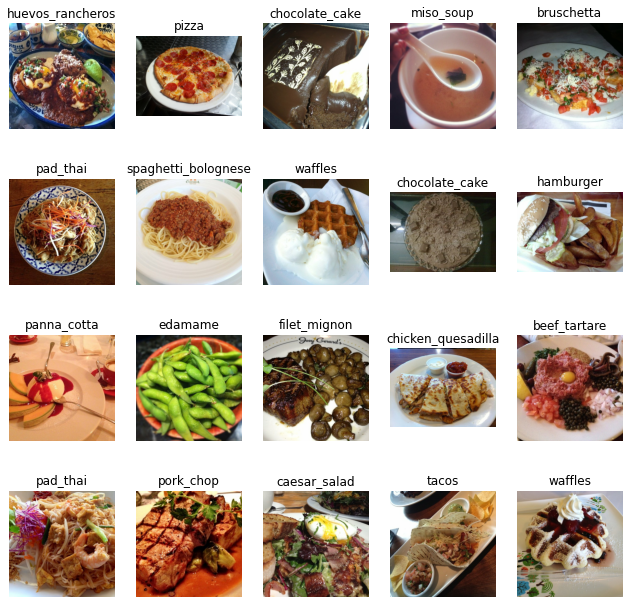

In [4]:
some_samples = [x for x in iter(train_ds.take(20))]

fig = plt.figure(figsize=(11, 11))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 5, j+1)
    ax.imshow(some_samples[j][0])
    label = some_samples[j][1].numpy()
    title = ds_info.features['label'].int2str(label)
    ax.set_title(title)
    plt.axis('off')
plt.show()

In [0]:
IMP_SIZE = 228
NUM_EPOCHS = 10
BATCH_SIZE = 128
NUM_CLASSES = 101

In [0]:
def prepare(img, label):
    img = tf.cast(img, tf.float32) / 255. # не от 0 до 1 (/255.), f jn -1 lj 1
    label = tf.one_hot(indices=tf.cast(label, tf.int32), depth=NUM_CLASSES)
    return tf.image.resize(img, (IMP_SIZE, IMP_SIZE)), label

def custom_augmentation(image,label):
    augment = np.random.choice([0, 1])
    if augment:
        return image, label

    flip_left_right, central_crop, rot90, random_saturation = \
        np.random.choice([0, 1], size=4)

    if flip_left_right:
      image = tf.image.flip_left_right(image)
    if central_crop:
      image = tf.image.central_crop(image, central_fraction=0.5)
    if rot90:
      image = tf.image.rot90(image)
    if random_saturation:
      image = tf.image.random_saturation(image, 0.1, 3)

    return image, label

train_ds = train_ds.shuffle(buffer_size=10000)
train_ds = train_ds.map(custom_augmentation)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=10000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [0]:
base_model = tf.keras.applications.VGG16(
    input_shape=(IMP_SIZE, IMP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine Tuning весов предобученной модели   
# base_model.trainable = False # заморозка весов предобученной модели 

# Размораживаем последний 5-й свёрточный блок
trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024*4, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [0]:
LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 101)               413797    
Total params: 17,229,733
Trainable params: 9,594,469
Non-trainable params: 7,635,264
_________________________________________________________________


In [11]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_set=test_ds
)

Epoch 1/10
591/591 [==============================] - 437s 739ms/step - loss: 2.9150 - accuracy: 0.2991
Epoch 2/10
591/591 [==============================] - 444s 750ms/step - loss: 2.0233 - accuracy: 0.4865
Epoch 3/10
591/591 [==============================] - 443s 749ms/step - loss: 1.7054 - accuracy: 0.5590
Epoch 4/10
591/591 [==============================] - 444s 751ms/step - loss: 1.4890 - accuracy: 0.6093
Epoch 5/10
591/591 [==============================] - 443s 750ms/step - loss: 1.3075 - accuracy: 0.6526
Epoch 6/10
591/591 [==============================] - 443s 749ms/step - loss: 1.1467 - accuracy: 0.6913
Epoch 7/10
591/591 [==============================] - 444s 751ms/step - loss: 1.0055 - accuracy: 0.7266
Epoch 8/10
591/591 [==============================] - 443s 750ms/step - loss: 0.8791 - accuracy: 0.7582
Epoch 9/10
591/591 [==============================] - 443s 750ms/step - loss: 0.7524 - accuracy: 0.7908
Epoch 10/10
591/591 [==============================] - 442s 748m

In [12]:
%%time

test_loss, test_accuracy = model.evaluate(test_ds)

197/197 [==============================] - 132s 671ms/step - loss: 1.4156 - accuracy: 0.6479
CPU times: user 2min 41s, sys: 44.5 s, total: 3min 26s
Wall time: 2min 37s


--2020-04-17 20:52:21--  https://pbs.twimg.com/media/EQDCPU-UcAEqjD4.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.237.96, 2606:2800:248:1707:10d3:19d0:1ba2:1a23
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.237.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136759 (134K) [image/jpeg]
Saving to: ‘EQDCPU-UcAEqjD4.jpg’

EQDCPU-UcAEqjD4.jpg 100%[===================>] 133.55K  --.-KB/s    in 0.002s  

2020-04-17 20:52:21 (63.7 MB/s) - ‘EQDCPU-UcAEqjD4.jpg’ saved [136759/136759]



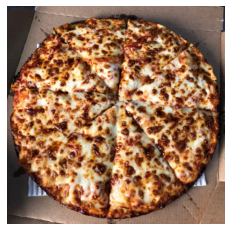

In [13]:
import imageio
from skimage.transform import resize

def prepare_img(img):
    img = img.astype(np.float32) / 255.
    img = resize(img, (IMP_SIZE, IMP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://pbs.twimg.com/media/EQDCPU-UcAEqjD4.jpg

img = imageio.imread('EQDCPU-UcAEqjD4.jpg', pilmode='RGB')
plt.imshow(img)
plt.axis('off')

img = prepare_img(img)

In [30]:
import pandas as pd

pred = model(img[None, ...], training=False).numpy()
top5 = pd.Series(pred[0], name='Probability').sort_values(ascending=False).head(5)
top5.index = [ds_info.features['label'].int2str(label) for label in top5.index]
print(top5)

pizza                  0.993613
carrot_cake            0.002633
garlic_bread           0.001763
red_velvet_cake        0.001231
macaroni_and_cheese    0.000304
Name: Probability, dtype: float32


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model.save('/content/drive/My Drive/VGG16.h5')